In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lu # compute LU decomposition
from scipy.optimize import minimize # minimization of scalar function

# 1. Generate location data $X$

In [20]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):  
    x_coords = np.random.normal(xmu, xsd, size=N_points)
    y_coords = np.random.normal(ymu, ysd, size=N_points)
    coords = np.column_stack((x_coords, y_coords))
    return coords

In [21]:
# function that calculates distances between coordinates
def distances(coords):
    N = len(coords)
        
    # Initialize an empty distances matrix
    distances = np.zeros((N, N))

    # Compute the euclidean distance between pair of coords
    for i in range(N):
        for j in range(i+1, N):
            distances[i,j] = distances[j,i] = np.linalg.norm(coords[i] - coords[j])       

    return distances

In [22]:
np.random.seed(100)

In [23]:
# set parameters
p = 10 # dimensionaltiy

In [24]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)
X

array([[-1.74976547, -0.45802699],
       [ 0.3426804 ,  0.43516349],
       [ 1.1530358 , -0.58359505],
       [-0.25243604,  0.81684707],
       [ 0.98132079,  0.67272081],
       [ 0.51421884, -0.10441114],
       [ 0.22117967, -0.53128038],
       [-1.07004333,  1.02973269],
       [-0.18949583, -0.43813562],
       [ 0.25500144, -1.11831825]])

In [25]:
# get distances
d = distances(X)

# 2. Covariance Matrix $\Sigma$
$$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) \\ d_{ij} = ||X_i - X_j||$$

In [26]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [27]:
# get SigmaTrue
paramTrue = [1, 1/2] 
SigmaTrue = Sigma(paramTrue, d)

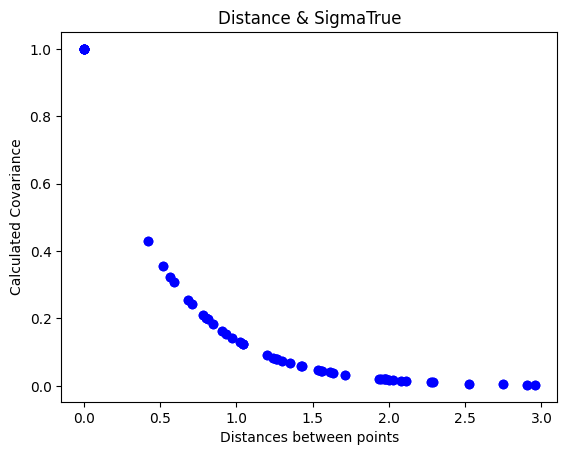

In [28]:
# plotting
d_plot = d.reshape((p*p,))
Sigma_plot = SigmaTrue.reshape((p*p,))
data = pd.DataFrame({'Distances': d_plot, 'Calculated Covariance': Sigma_plot})

plt.scatter(data['Distances'], data['Calculated Covariance'], c='blue')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.title('Distance & SigmaTrue')
plt.show()

# 3. Generate data $Y$
$ Y = \Sigma^{1/2} \cdot U $ 
* $\Sigma$ is positive semi definite 
* $U \sim N(0, I_p)$


Thus, $Y \sim N(0, \Sigma) $

cf. Getting $\Sigma^{1/2}$
* Choleskey factorization
    * Conditions: 1) Positive Definite, 2) Square, 3) Symmetric (No need to check condition 2 & 3 as Sigma is covariance matrix)



In [29]:
# check if SigmaTrue is positive definite
## cf. pd <-> all eigenvalues > 0
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue) 
    print('Covariance matrix is positive definite')
else: 
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [30]:
# generate y
U = np.random.normal(0, 1, p).reshape(p, 1)
Y = np.dot(SigmaHalf, U)
Y.shape # check the dimensionality of Y

(10, 1)

# 4. Parameter Estimation

$$ logL(\vec{\theta};\vec{Y}) = -\frac{1}{2} \log ( |\Sigma(\theta)|) - \frac{1}{2} \vec{Y}^T (\Sigma(\theta))^{-1} \vec{Y} $$

1. $\log ( |\Sigma(\theta)|$
* Using the mathematical fact that the determinant of a triangular matrix equals the product of its diagonal elements, we use matrix factorization to get determinants to prevent over/underflow issue (that occurs when trying to calculate the determinant of large matrices) in this case.

* Check if the matrix is positive definite or not.
    * 1-1) If the matrix is positive definite: use choleskey factorization
    * 1-2) Is the matrix is not positive definite: use LU factorization

2. $\Sigma(\theta))^{-1}$
* Check if the matrix is invertible or not.

In [31]:
def check_pd(Sigma):
  try:
    pd = np.linalg.eig(Sigma)[0].min() 
    if pd > 0:
      return True
  except np.linalg.LinAlgError:
    return False

In [32]:
# check invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

## 4-1. Likelihood function

In [33]:
# define log likelihood function
def logLikelihood(param, Y):
    
    p = len(Y)
    sig = Sigma(param, d)
    chol = check_pd(sig) 
    inv = check_invertible(sig)
    
    if chol: 
      # choleskey factorization
      log_det_Sigma = 2 * np.sum(np.log(np.diag(np.linalg.cholesky(sig))))
    else: 
       # LU factorization
       P, L, U = lu(sig)
       sign_P = np.linalg.det(P)
       log_det_Sigma = np.log(np.abs((-1) ** sign_P * np.prod(np.diag(U))))
        
    
    if inv:
        inv_Sigma = np.linalg.inv(sig)
    else:   
        inv_Sigma = np.linalg.pinv(sig) # pseudo inverse
    
        
    return 0.5 * Y.T @ inv_Sigma @ Y + 0.5 * log_det_Sigma

## 4-2. MLE

In [34]:
param0 = paramTrue

                
# Define the optimization problem
problem = {
    'fun': logLikelihood,         # Objective function: minimize the minimum eigenvalue
    'x0': paramTrue,            # Initial guess for the parameters
    'args': (Y,),             # Additional arguments for the objective function 
    'method': 'BFGS'        
}

result = minimize(**problem)

estimated_params = result.x

In [35]:
print("MLE = ", estimated_params)

MLE =  [1.03308982 0.86858257]


## 4-3. MLE Distribution


In [36]:
mle0_lst = [] # param0
mle1_lst = [] # param1

for i in range(100):
    # Generate SigmaTrue
    while True:
        X = make_coords(p, *coord)
        d = distances(X)
        SigmaTrue = Sigma(paramTrue, d)
        
        if check_pd(SigmaTrue):
            break  # exit the while loop if SigmaTrue is positive definite

    SigmaHalf = np.linalg.cholesky(SigmaTrue)

    # Generate Y
    U = np.random.normal(0, 1, p).reshape(p, 1)
    Y = np.dot(SigmaHalf, U)

    # MLE
    result = minimize(**problem)
    mle0, mle1 = result.x[0], result.x[1]
    mle0_lst.append(mle0)
    mle1_lst.append(mle1)


    if i % 10 == 0:
          print(f"Processing epoch {i}")
          print(f"{i}th MLE: ", mle0, mle1)

Processing epoch 0
0th MLE:  1.1225083998362875 0.578200893131902
Processing epoch 10
10th MLE:  0.875830213087891 0.8136133371247721
Processing epoch 20
20th MLE:  0.9988592439570051 1.0941032353644022
Processing epoch 30
30th MLE:  1.213120779500496 0.4298094613360972
Processing epoch 40
40th MLE:  1.0927967830824057 0.23627417075289447
Processing epoch 50
50th MLE:  1.1062554452784759 1.2457710925856593


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Processing epoch 60
60th MLE:  1.288207169846355 0.050454290409424174
Processing epoch 70
70th MLE:  0.1937784513178599 -1.277027838319951
Processing epoch 80
80th MLE:  0.9952375845924668 0.038345514413469284
Processing epoch 90
90th MLE:  1.0611868803142106 2.1999669414301315


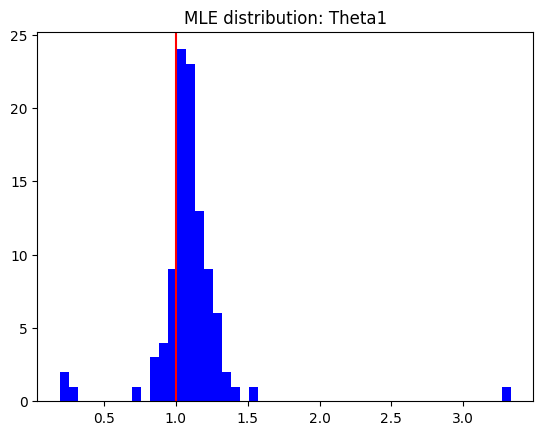

In [37]:
plt.hist(mle0_lst,bins=50,color='b')
plt.axvline(x=1, color='r')
plt.title('MLE distribution: Theta1')
plt.show()

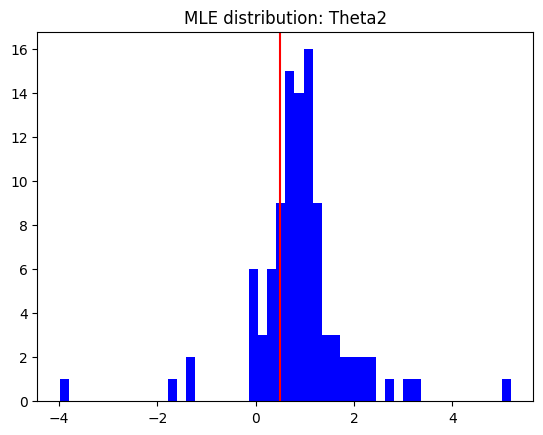

In [38]:
plt.hist(mle1_lst, bins=50, color='b')
plt.axvline(x=0.5, color='r')
plt.title('MLE distribution: Theta2')
plt.show()